# Fine-tuning a masked language model (PyTorch)

## Background

- For many NLP applications involving Transformer models, you can simply take a pretrained model from the Hugging Face Hub and fine-tune it directly on your data for the task at hand. Provided that the corpus used for pretraining is not too different from the corpus used for fine-tuning, transfer learning will usually produce good results.

- However, there are a few cases where you’ll want to first fine-tune the language models on your data, before training a task-specific head. For example, if your dataset contains legal contracts or scientific articles, a vanilla Transformer model like BERT will typically treat the domain-specific words in your corpus as rare tokens, and the resulting performance may be less than satisfactory. By fine-tuning the language model on in-domain data you can boost the performance of many downstream tasks, which means you usually only have to do this step once!

- This process of fine-tuning a pretrained language model on in-domain data is usually called **domain adaptation**. It was popularized in 2018 by `ULMFiT`(https://arxiv.org/abs/1801.06146), which was one of the first neural architectures (based on LSTMs) to make transfer learning really work for NLP.

An example of domain adaptation with ULMFiT is shown in the image below; in this section we’ll do something similar, but with a Transformer instead of an LSTM!

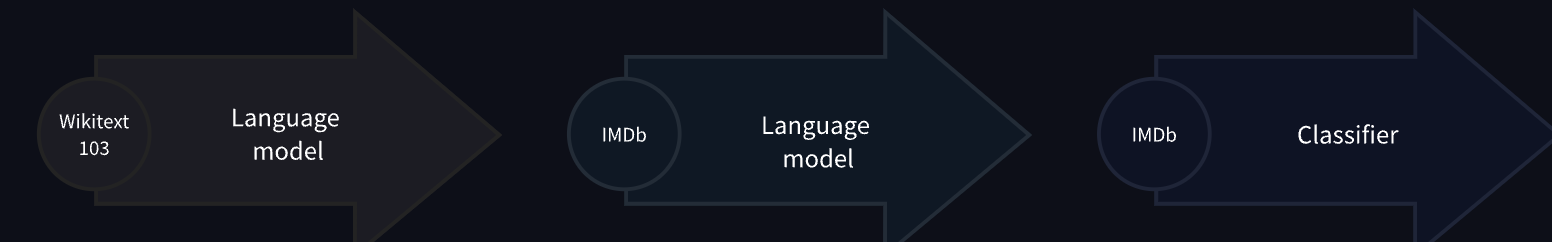

# Picking a pretrained model for masked language modeling
To get started, let’s pick a suitable pretrained model for masked language modeling. As shown in the following screenshot, you can find a list of candidates by applying the “Fill-Mask” filter on the *Hugging Face Hub*:

Although the **BERT and RoBERTa** family of models are the most downloaded, we’ll use a model called `DistilBERT` that can be trained much faster with little to no loss in downstream performance. This model was trained using a special technique called `knowledge distillation`, where a large “teacher model” like BERT is used to guide the training of a “student model” that has far fewer parameters.

An explanation of the details of knowledge distillation would take us too far afield in this section, but if you’re interested you can read all about it in *Natural Language Processing with Transformers* (colloquially known as the Transformers textbook).

Let’s go ahead and download DistilBERT using the AutoModelForMaskedLM class:



Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [ ]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'

With around 67 million parameters, DistilBERT is approximately two times smaller than the BERT base model, which roughly translates into a two-fold speedup in training — nice! Let’s now see what kinds of tokens this model predicts are the most likely completions of a small sample of text:

In [ ]:
text = "This is a great [MASK]."

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'

We can see from the outputs that the model’s predictions refer to everyday terms, which is perhaps not surprising given the foundation of English Wikipedia. Let’s see how we can change this domain to something a bit more niche — highly polarized movie reviews!

# The Dataset

To showcase domain adaptation, we’ll use the famous **Large Movie Review Dataset** (or `IMDb` for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models.

By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews. We can get the data from the Hugging Face Hub with the `load_dataset() `function from 🤗 Datasets:

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: This is your typical Priyadarshan movie--a bunch of loony characters out on some silly mission. His signature climax has the entire cast of the film coming together and fighting each other in some crazy moshpit over hidden money. Whether it is a winning lottery ticket in Malamaal Weekly, black money in Hera Pheri, "kodokoo" in Phir Hera Pheri, etc., etc., the director is becoming ridiculously predictable. Don\'t get me wrong; as clichéd and preposterous his movies may be, I usually end up enjoying the comedy. However, in most his previous movies there has actually been some good humor, (Hungama and Hera Pheri being noteworthy ones). Now, the hilarity of his films is fading as he is using the same formula over and over again.<br /><br />Songs are good. Tanushree Datta looks awesome. Rajpal Yadav is irritating, and Tusshar is not a whole lot better. Kunal Khemu is OK, and Sharman Joshi is the best.'
'>>> Label: 0'

'>>> Review: Okay, the story makes no sense, the characters

# Preprocessing the dataset

For both auto-regressive and masked language modeling, a common preprocessing step is to concatenate all the examples and then split the whole corpus into chunks of equal size. This is quite different from our usual approach, where we simply tokenize individual examples. Why concatenate everything together? The reason is that individual examples might get truncated if they’re too long, and that would result in losing information that might be useful for the language modeling task!

So to get started, we’ll first tokenize our corpus as usual, but without setting the truncation=True option in our tokenizer. We’ll also grab the word IDs if they are available ((which they will be if we’re using a fast tokenizer, as described in Chapter 6), as we will need them later on to do whole word masking. We’ll wrap this in a simple function, and while we’re at it we’ll remove the text and label columns since we don’t need them any longer:

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'word_ids'],
        num_rows: 50000
    })
})

In [ ]:
tokenizer.model_max_length

512

In [ ]:
chunk_size = 128

In [ ]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 200'
'>>> Review 1 length: 559'
'>>> Review 2 length: 192'

In [ ]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 951'

Great, the total length checks out — so now let’s split the concatenated reviews into chunks of the size given by `chunk_size`. To do so, we iterate over the features in concatenated_examples and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:


In [ ]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 55'

As you can see in this example, the last chunk will generally be smaller than the maximum chunk size. There are two main strategies for dealing with this:

Drop the last chunk if it’s smaller than chunk_size.
Pad the last chunk until its length equals chunk_size.
We’ll take the first approach here, so let’s wrap all of the above logic in a single function that we can apply to our tokenized datasets:


In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 61289
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 59905
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 122963
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

".... at.......... high. a classic line : inspector : i'm here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn't! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. most people think of the homeless"

# Fine-tuning DistilBERT with the Trainer API
Fine-tuning a masked language model is almost identical to fine-tuning a sequence classification model, like we did in Chapter 3. The only difference is that we need a special data collator that can randomly mask some of the tokens in each batch of texts. Fortunately, 🤗 Transformers comes prepared with a dedicated `DataCollatorForLanguageModeling` for just this task.

We just have to pass it the tokenizer and an `mlm_probability` argument that specifies what fraction of the tokens to mask. We’ll pick **15%,** which is the amount used for BERT and a common choice in the literature:

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

When training models for masked language modeling, one technique that can be used is to mask whole words together, not just individual tokens. This approach is called `whole word masking`.

If we want to use whole word masking, we will need to build a data collator ourselves. A data collator is just a function that takes a list of samples and converts them into a batch, so let’s do this now! We’ll use the word IDs computed earlier to make a map between word indices and the corresponding tokens, then randomly decide which words to mask and apply that mask on the inputs. Note that the labels are all -100 except for the ones corresponding to mask words.


In [ ]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

'>>> [CLS] bromwell high is a cartoon comedy [MASK] it ran at the same time as some other programs about school life, such as " teachers ". my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is " teachers ". the scramble to survive financially, the insightful students who can see right through their pathetic teachers\'pomp, the pettiness of the whole situation, all remind me of the schools i knew and their students. when i saw the episode in which a student repeatedly tried to burn down the school, i immediately recalled.....'

'>>> .... [MASK] [MASK] [MASK] [MASK]....... high. a classic line : inspector : i\'m here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn\'t! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the st

Now that we have two data collators, the rest of the fine-tuning steps are standard.

Training can take a while on Google Colab if you’re not lucky enough to score a mythical P100 GPU 😭, so we’ll first *downsample* the size of the training set to a few thousand examples.

Don’t worry, we’ll still get a pretty decent language model! A quick way to downsample a dataset in 🤗 Datasets is via the Dataset.train_test_split() function that we saw in Chapter 5:

In [ ]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 1000
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Perplexity for language models

Unlike other tasks like text classification or question answering where we’re given a labeled corpus to train on, with language modeling we don’t have any explicit labels. So how do we determine what makes a good language model? Like with the autocorrect feature in your phone, a good language model is one that assigns high probabilities to sentences that are grammatically correct, and low probabilities to nonsense sentences. To give you a better idea of what this looks like, you can find whole sets of `“autocorrect fails”` online, where the model in a person’s phone has produced some rather funny (and often inappropriate) completions!

Assuming our test set consists mostly of sentences that are grammatically correct, then one way to measure the quality of our language model is to **calculate the probabilities it assigns to the next word in all the sentences of the test set.** High probabilities indicates that the model is not “surprised” or “perplexed” by the unseen examples, and suggests it has learned the basic patterns of grammar in the language. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss. Thus, we can calculate the perplexity of our pretrained model by using the `Trainer.evaluate()` function to **compute the cross-entropy loss** on the test set and then taking the exponential of the result:

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 21.75

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 11.32

In [ ]:
trainer.push_to_hub()

# Fine-tuning DistilBERT with 🤗 Accelerate
As we saw with the Trainer, fine-tuning a masked language model is very similar to the text classification example from Chapter 3. In fact, the only subtlety is the use of a special data collator, and we’ve already covered that earlier in this section!

However, we saw that `DataCollatorForLanguageModeling` also applies random masking with each evaluation, so we’ll see some fluctuations in our perplexity scores with each training run. One way to eliminate this source of randomness is to apply the masking once on the whole test set, and then use the default data collator in 🤗 Transformers to collect the batches during evaluation.

To see how this works, let’s implement a simple function that applies the masking on a batch, similar to our first encounter with DataCollatorForLanguageModeling:

In [ ]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'lewtun/distilbert-base-uncased-finetuned-imdb-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

>>> Epoch 0: Perplexity: 11.397545307900472
>>> Epoch 1: Perplexity: 10.904909330983092
>>> Epoch 2: Perplexity: 10.729503505340409

# Using our fine-tuned model
You can interact with your fine-tuned model either by using its widget on the Hub or locally with the pipeline from 🤗 Transformers. Let’s use the latter to download our model using the fill-mask pipeline:

In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

'>>> this is a great movie.'
'>>> this is a great film.'
'>>> this is a great story.'
'>>> this is a great movies.'
'>>> this is a great character.'